## Probleme sur la locomotion 

Ce notebook contient la realisation d’un système simple pouvant se déplacer de façon autonome offre plusieurs avantages (robotique,micro/nanotechnologies pour le transport de medicaments,realisation de systèmes d’assistance au déplacement, etc.).

## Partie I:  

## Déplacement en ligne droite 

Hexapod

Avant
|0 3|
|1 4|
|2 5|
Arriere

In [264]:
from brian2 import *
%matplotlib inline
prefs.codegen.target = "numpy"

Equation differentielle du model (Leaky integrate-and-fire)

In [265]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1 
I : 1
tau : second
counter : 1
'''

#### NeuroneGroup des pattes 
la valeur de tau est 1500s  pour ne pas avoir beaucoup de fuite pour ne pas influencer la fréquence de décharge


In [266]:
nbr_pattes = 6

pattes = NeuronGroup(nbr_pattes, eqs,threshold='v>0.9', reset='v = 0',   method='exact')
pattes.I = 0
pattes.tau = 1500*ms
MP = StateMonitor(pattes, 'v', record=True)

#### NeuroneGroup des motoneurones
C'est neurones seront les exitateurs des neurones des pattes

In [270]:
CPG = NeuronGroup(2, eqs,threshold='v>0.9', reset='v = 0', method='exact')
CPG.I = [2,0]
CPG.tau = 10*ms
M = StateMonitor(CPG, 'v', record=True)

#### Synapse motoneurone/pattes
Tous les motoneurones sont connécter avec toutes les pattes 

CPG1 : sont poid est 0.1 cette valeur permet à la pattes de décharger 1 fois dans 80ms (1 décharge/80ms = déplacement en avant)

CPG2 : sont poid est 0.2 cette valeur permet à la pattes de décharger 2 fois dans 80ms (2 décharge/80ms = déplacement en arrière)

 les délais des connexions sont définis de telle façon à ce que chaque paire de patte aura un 2*délai de la paire précédente le but est d'avoir un mouvement séquentiel


In [268]:
Scpg_pattes = Synapses(CPG, pattes, 'w : 1', on_pre='v_post += w')
delai = 8*ms
for k in range(0,2):
    Scpg_pattes.connect(i=k, j=range(nbr_pattes))
    Scpg_pattes.w[k,range(nbr_pattes)] = '(k+1)*0.1'
    for f in range(0, nbr_pattes//2):
        Scpg_pattes.delay[k,f] = Scpg_pattes.delay[k,f + nbr_pattes//2] = 8*f*ms
        

        

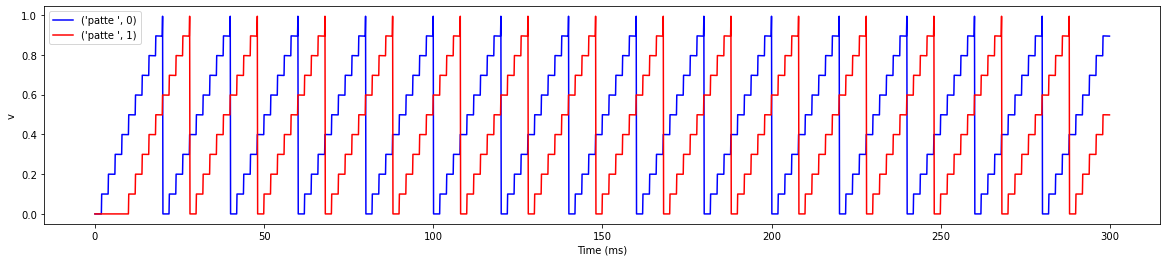

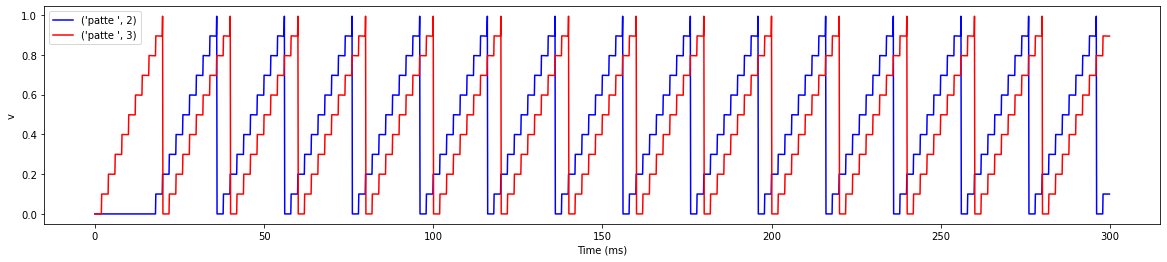

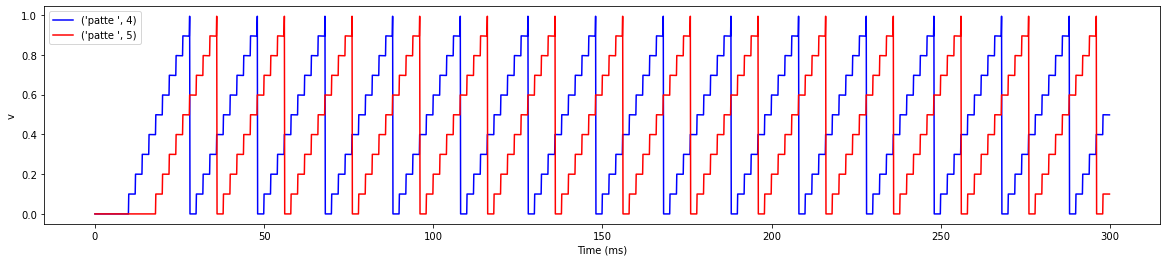

In [269]:
run(300*ms)

for i in range (0,5,2):
    figure(figsize=(20, 4))
    patteNum = 'patte ',i
    plot(MP.t/ms, MP.v[i], color='blue', label=patteNum)
    
    patteNum = 'patte ',i+1
    plot(MP.t/ms, MP.v[i+1], color='red', label=patteNum)

    xlabel('Time (ms)')
    ylabel('v')
    
    legend()

## Partie II: 

In [272]:
from brian2 import *
%matplotlib inline
prefs.codegen.target = "numpy"

start_scope()


### Hypothèses: 

-Chaque patte est controllée par un seul neurone qui lui permet de mouvoir en avant/arrière, et qui permet aussi à la partie du corps au voisinage de cette patte de faire une rotation à gauche/droite.

le nombre de décharge du neurone par 80ms
   * rotation droite : 1 décharge.
   * déplacement en avant : 2 décharges.
   * rotation gauche : 3 décharges.
   * le delplacement en arrière : 4 décharges.
   * l'accélération : 5 décharge.
   


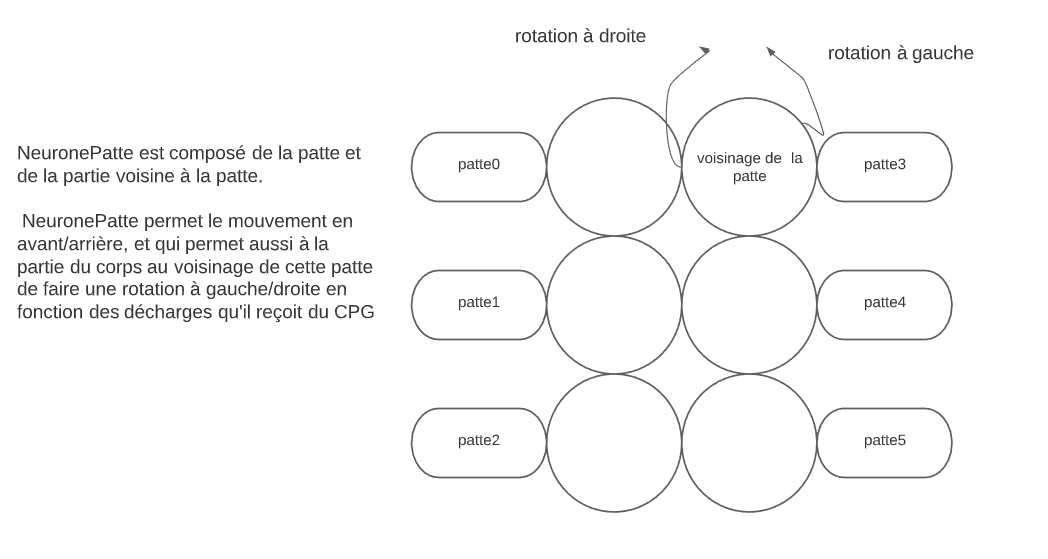

In [282]:
#LIF
eqs = '''
dv/dt = (I-v)/tau : 1 
I : 1
tau : second
counter : 1
'''
#LIF avec période réfractaire
eqs_avec_refratoriness = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I : 1
tau : second
refractoriness : second
'''

## Architecture

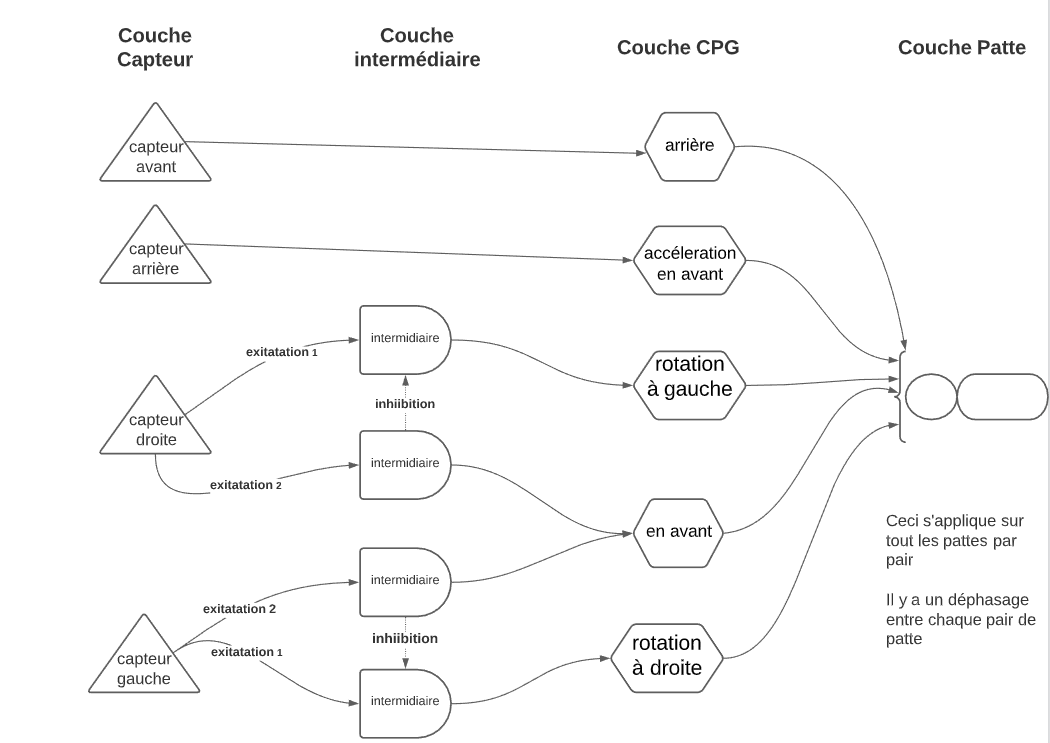

### NeuroneGroup des pattes 
la valeur de tau est 1000s  pour ne pas avoir beaucoup de fuite pour ne pas influencer la fréquence de décharge


In [283]:
nbr_pattes = 6

pattes = NeuronGroup(nbr_pattes, eqs,threshold='v>0.9', reset='v = 0',   method='exact')
pattes.I = 0
pattes.tau = 1000*ms
MP = StateMonitor(pattes, 'v', record=True)

### NeuroneGroup des motoneurones 


In [284]:
CPG = NeuronGroup(5, eqs,threshold='v>0.9', reset='v = 0', method='exact')
CPG.I = [0,0,0,0,0]
CPG.tau = 10*ms
M = StateMonitor(CPG, 'v', record=True)

### NeuroneGroup connecteur de la couche des motoneurones et des capteurs
Cette couche comporte 8 neurone pour manipuler les motoneurones.
* cpg_inter0 et cpg_inter1 sont utilisés pour générer la rotation droite puis l'avancement continu vers l'avant ceci se produira quand il y aura un obstacle à gauche de l'hexapode
* cpg_inter2, cpg_inter3 et cpg_inter4 sont utilisés pour générer la rotation gauche puis l'avancement continu vers l'avant ceci se produira quand il y aura un obstacle à droite de l'hexapode
* cpg_inter5, cpg_inter6 et cpg_inter7 sont utilisés pour générer le mouvement cerculaire


In [285]:

cpg_inter= NeuronGroup(8, eqs_avec_refratoriness, threshold='v>0.9', refractory = 'refractoriness', reset='v = 0', method='exact')
cpg_inter.refractoriness = [0, 2.25, 0, 0, 1.65, 0, 0, 2.25]*ms
cpg_inter.I = [0, 0, 0, 0, 0, 0, 0, 0]
cpg_inter.tau = 10*ms
Mcpg_inter = StateMonitor(cpg_inter, 'v', record=True)

### NeuroneGroup des capteurs 
* Capteur 0: quand ce capteur décharge (présence d'obstacle à droite de l'hexapode) il permet à l'hexapode de faire une rotation à gauche puis marcher en avant en passant par des neurones intermediaires
* Capteur 1: quand ce capteur décharge (présence d'obstacle derrière l'hexapode) il permet à l'hexapode de d'accélérer en passant par des neurones intermediaires 
* Capteur 2: quand ce capteur décharge (présence d'obstacle à gauche de l'hexapode) il permet à l'hexapode de faire une rotation à droite puis marcher en avant en passant par des neurones intermediaires
* Capteur 3: quand ce capteur décharge (présence d'obstacle devant l'hexapode) il permet à l'hexapode de reculer en passant par des neurones intermediaires

In [286]:
capteurs = NeuronGroup(4, eqs_avec_refratoriness,threshold='v>0.9', refractory = 'refractoriness', reset='v = 0', method='exact')
capteurs.refractoriness = [2.25, 2.25, 0.8, 0.8]*ms
capteurs.I = [0,0,0,0]
capteurs.tau = 10*ms
MC = StateMonitor(capteurs, 'v', record=True)


### Synapse motoneurone/pattes
 Tous les motoneurones sont connécter avec toutes les pattes
* CPG0 : sont poid est 0.1 cette valeur permet à la pattes de décharger une fois dans 80ms (1 décharge/80ms = rotation droite)
* CPG1 : sont poid est 0.2 cette valeur permet à la pattes de décharger 2 fois dans 80ms (2 décharge/80ms = déplacement en avant)
* CPG2 : sont poid est 0.3 cette valeur permet à la pattes de décharger 3 fois dans 80ms (3 décharge/80ms = rotation gauche)
* CPG3 : sont poid est 0.4 cette valeur permet à la pattes de décharger 4 fois dans 80ms (4 décharge/80ms = déplacement en arrière) 
* CPG4 : sont poid est 0.5 cette valeur permet à la pattes de décharger 5 fois dans 80ms (5 décharge/80ms = déplacement en arrière)

** les délais des connexions sont définis de telle façon à ce que chaque paire de patte aura un 2xdélai de la paire précédente le but est d'avoir un mouvement séquentiel



In [287]:
Scpg_pattes = Synapses(CPG, pattes, 'w : 1', on_pre='v_post += w')
delai = 8*ms
for k in range(0,5):
    Scpg_pattes.connect(i=k, j=range(nbr_pattes))
    Scpg_pattes.w[k,range(nbr_pattes)] = '(k+1)*0.1'
    for f in range(0, nbr_pattes//2):
        Scpg_pattes.delay[k,f] = Scpg_pattes.delay[k,f + nbr_pattes//2] = 8*f*ms
    


### Synapse motoneurones intermédiaire/ motoneurones
* cpg_inter0 : excite CPG0 (rotation droite)
* cpg_inter1 : excite CPG1 et hinibe cpg_inter0 après un delai de 80 ms : quand cpg_inter0 décharge la patte fait une rotation droite biensur dans 80 ms (c'est le temps de reflexe) puis cpg_inter0 est hinibé par cpg_inter1 qui excite en meme temps CPG1 pour arreter la rotation est debuter l'avance ment vers l'avant
* cpg_inter2 : excite CPG2 (rotation gauche)

* cpg_inter3 : exite CPG1 et hinibe cpg_inter2 après un delai de 80 ms : quand cpg_inter2 décharge la patte fait une rotation gauche biensur dans 80 ms (c'est le temps de reflexe) puis cpg_inter2 est hinibé par  cpg_inter3 qui exite en meme temps cpg_inter4 qui excite CPG1 pour arreter la rotation est debuter l'avancement vers l'avant
* cpg_inter4 : est utilisé juste pour adapter la fréquance


In [288]:
Scpg_inter_cpg = Synapses(cpg_inter, CPG, 'w : 1', on_pre='v_post += w')
Scpg_inter_cpg.connect(i=0, j=0)
Scpg_inter_cpg.connect(i=1, j=1)
Scpg_inter_cpg.connect(i=4, j=1)
Scpg_inter_cpg.connect(i=2, j=2)
Scpg_inter_cpg.connect(i=5, j=0)
Scpg_inter_cpg.connect(i=6, j=1)
Scpg_inter_cpg.w = 1

Scpg_inter_cpg_inter_hinibitrice = Synapses(cpg_inter, cpg_inter, 'w : 1', on_pre='v_post -= w')
Scpg_inter_cpg_inter_hinibitrice.connect(i=1, j=0)
Scpg_inter_cpg_inter_hinibitrice.connect(i=3, j=2)
Scpg_inter_cpg_inter_hinibitrice.connect(i = 6,j = [5, 6])
Scpg_inter_cpg_inter_hinibitrice.delay[6,6] = 80*ms
Scpg_inter_cpg_inter_hinibitrice.w = 1

SCercle_inter_cpg_inter = Synapses(cpg_inter, cpg_inter, 'w : 1', on_pre='v_post += w')
SCercle_inter_cpg_inter.connect(i=7, j=[5, 6])
SCercle_inter_cpg_inter.delay[7,6] = (80)*ms
SCercle_inter_cpg_inter.w = 1



### Synapse capteurs/motoneurones intermedaires
* capteur0 (capteur gauche) excite cpg_inter0 pour faire une rotation droite et cpg_inter1 avec un delai 80ms pour l'avancement en avant 
* capteur1 (capteur arrière) excite CPG4 pour générer l'accéleration on a pas besoin de passer par motoneurone intermediaire
* capteur2 (capteur droite) excite cpg_inter2 pour faire une rotation gauche et cpg_inter3 avec un delai 80ms pour l'avancement en avant
* capteur3 (capteur avant) excite CPG3 pour générer le recul on a pas besoin de passer par motoneurone intermediaire

In [289]:
Scapteurs_cpg_inter = Synapses(capteurs, cpg_inter, 'w : 1', on_pre='v_post += w')
Scapteurs_cpg_inter.connect(i=0, j=[0,1])
Scapteurs_cpg_inter.connect(i=2, j=[2,3])

Scapteurs_cpg_inter.delay[0,1] = 80*ms
Scapteurs_cpg_inter.delay[2,3] = 80*ms

Scapteurs_cpg_inter.w = 1

Scapteurs_cpg = Synapses(capteurs, CPG, 'w : 1', on_pre='v_post += w')
Scapteurs_cpg.connect(i=3, j=3)
Scapteurs_cpg_inter.w = 1

Scapteurs_cpg = Synapses(capteurs, CPG, 'w : 1', on_pre='v_post += w')
Scapteurs_cpg.connect(i=1, j=4)
Scapteurs_cpg_inter.w = 1




